Create a Research Agent.

In [ ]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("What are the proper guidelines for disposing of batteries in NYC?")

print(web_search_results["results"][0]["content"])

Under the Law, manufacturers of covered rechargeable batteries or groups of collaborating manufacturers are responsible for financing the collection and recycling of all rechargeable batteries collected by retailers, as well as providing outreach and education to NYS consumers regarding the proper way to recycle rechargeable batteries. Protect people, property, and the environment by recycling your used rechargeable batteries at any [insert retailer name] New York store or at a participating drop-off location. The NYS Department of Environmental Conservation has within its authority the right to inspect retailers of rechargeable batteries or rechargeable battery containing products for compliance with the Law. An example retail inspection form is provided here (177KB PDF) for your information.


In [2]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [2]:
test

NameError: name 'test' is not defined

In [4]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [5]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "What are the proper guidelines for disposing of batteries in NYC?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_XV77GqExVIaOYgLD3RHQV1Io)
 Call ID: call_XV77GqExVIaOYgLD3RHQV1Io
  Args:
    query: battery disposal guidelines in NYC
    include_domains: ['nyc.gov']
    search_depth: basic


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "battery disposal guidelines in NYC", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://portal.311.nyc.gov/article/?kanumber=KA-01973", "title": "Special Waste Disposal · NYC311 - NYC.gov", "content": "NYC residents can drop off non-commercial special waste at **Special Waste Sites** and **SAFE Disposal Events**. | Item | Special Waste Site | SAFE Disposal Event | If an item isn’t accepted by a Special Waste Site or a SAFE Event, or if you’re unable to drop off an item, you may 

In [6]:
import os
import requests

GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

def get_places(query: str, latitude: float, longitude: float) -> dict:
    """Function that leverages the Google Places API to find locations near the latidute and longitude given.

    Args:
        query: The type of location you are searching for (in example "Recycling center")
        latitude: The current latitude of the user
        longitude: The current longitude of the user

    Returns:
        Dictionary with location details, results and metadata
    """
    #the google api url
    url = 'https://places.googleapis.com/v1/places:searchText'
    #headers used for the request
    headers = {
        'Content-Type': 'application/json',
        'X-Goog-Api-Key': GOOGLE_API_KEY,
        'X-Goog-FieldMask': '*'
    }
    #the request body used for the api request
    request_body = {
        "textQuery": query,
        "locationBias": {
            "circle": {
                "center": {
                    "latitude": latitude,
                    "longitude": longitude
                },
                "radius": 100.0
            }
        }
    }
    #get the response
    response = requests.post(url, headers=headers, json=request_body)
    #get the json object
    output = response.json()
    #save the locations in a dictionary
    locations = []
    #loop through the output
    for row in output['places']:
        locations.append({
            "name": row["displayName"]["text"],
            "address": row["formattedAddress"],
            #TODO: contact information
        })
    return {
        "query": query,
        "latitude_used": latitude,
        "longitude_used": longitude,
        "results": locations
    }




In [7]:
locater_agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[get_places],
    prompt=(
        "You are a locater agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with locating-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="locater_agent",
)

In [8]:
for chunk in locater_agent.stream(
    {"messages": [{"role": "user", "content": "Where can I dispose of my batteries in Koreatown, Los Angeles."}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: locater_agent
Tool Calls:
  get_places (call_ukjfS9Q09D5ut5bgp0zjhQKU)
 Call ID: call_ukjfS9Q09D5ut5bgp0zjhQKU
  Args:
    query: battery disposal
    latitude: 34.0614
    longitude: -118.3081


Update from node tools:


================================= Tool Message =================================
Name: get_places

{"query": "battery disposal", "latitude_used": 34.0614, "longitude_used": -118.3081, "results": [{"name": "Greenly Electronics Recycling & Data Destruction", "address": "2542 W 3rd St, Los Angeles, CA 90057, USA"}, {"name": "Electronics Recycling (Best Buy)", "address": "1015 N La Brea Ave, West Hollywood, CA 90038, USA"}, {"name": "Star Recycling", "address": "2623 W Pico Blvd, Los Angeles, CA 90006, USA"}, {"name": "San Gabriel Recycling", "address": "1075 S Hoover St, Los Angeles, CA 90006, USA"}, {"name": "Temple Recycling Center", "address": "3521 W Templ

#### Supervisor Agent

In [ ]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4.1-mini"),
    agents=[research_agent, locater_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent, such as more information on city guidelines.\n"
        "- a locater agent. Assign locating-related tasks to this agent, such as finding places near a specific area.\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "You should use the research agent to inform yourself on the appropriate guidelines and then use the locater agent to give five locations for the user.\n"
        "You must also inform the user of any fines they could incur if they do not follow the guidelines.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

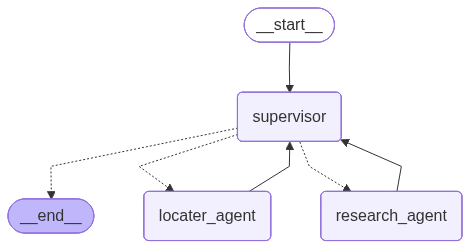

In [22]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [27]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Hello, somebody ran over a racoon and left it on the street, what should I do? By the way I live in Koreatown, Los Angeles.",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_locater_agent

Successfully transferred to locater_agent


Update from node locater_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

If you find a dead or injured raccoon in Koreatown, Los Angeles, you should avoid approaching or 

In [28]:
print(chunk["supervisor"]['messages'][-1].content)

If you find a dead or injured raccoon in Koreatown, Los Angeles, you should avoid approaching or touching it for safety reasons. You need to report it to the city by dialing 311, which connects you with Los Angeles Animal Services who will safely handle the situation.

Here are some nearby animal care and control locations that can assist you:
1. Animal Urgent Care K-Town, 3035 W Olympic Blvd, Los Angeles, CA 90006
2. County of Los Angeles Department of Animal Care and Control - Downey Animal Care Center, 11258 Garfield Ave, Downey, CA 90242
3. North Central Animal Shelter, 3201 Lacy St, Los Angeles, CA 90031
4. Shatto Veterinary Center, 3130 W 6th St, Los Angeles, CA 90020
5. South LA Animal Shelter, 1850 W 60th St, Los Angeles, CA 90047

Please note that improper handling or leaving dead wildlife on public streets may violate city regulations, potentially leading to fines, so it is best to report to official services right away.
